In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-


# Introduction to AI and OpenVino

## Lecture 09

### Neural Network with :
- One hidden layer 
- ${Tanh}$ activation function


<img src='../../prasami_images/prasami_color_tutorials_small.png' width='400' alt="By Pramod Sharma : pramod.sharma@prasami.com" align="left"/>

In [2]:
# Lets import some libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay

import tensorflow as tf

2024-06-15 19:00:47.382488: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-15 19:00:47.382542: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-15 19:00:47.383692: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-15 19:00:47.389966: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-15 19:00:48.353021: W tensorflow/compiler/tf2

In [3]:
# Some Basic Parameters for housekeeping

# set location of input files:
inpDir = os.path.join('..', '..', 'input')

# set location of inputs for this module
moduleDir = 'machine_learning'
# set location of output files
outDir = os.path.join('..', 'output')

# define and set random state 
RANDOM_STATE = 24
np.random.seed(RANDOM_STATE) # Set Random Seed for reproducible  results

# parameters for Matplotlib
params = {'legend.fontsize': 'medium',
          'figure.figsize': (15,6),
          'axes.labelsize': 'medium',
          'axes.titlesize':'large',
          'xtick.labelsize':'medium',
          'ytick.labelsize':'medium',
          'savefig.dpi': 75,
          'image.interpolation': 'none',
          'savefig.bbox' : 'tight',
          'lines.linewidth' : 1,
          'legend.numpoints' : 1
         }

CMAP = plt.cm.brg
plt.rcParams.update(params);
plt.set_cmap(CMAP);

plt.style.use('bmh')

EPOCHS = 500 # number of epochs
BATCH_SIZE = 32 # batch size
ALPHA = 0.001 # learning rate
NUM_SAMPLES = 1280 # How many samples we want to generate 
NOISE = 0.2 # Noise to be introduced in the data
TEST_SIZE = 0.2

<Figure size 1500x600 with 0 Axes>

### Helper Functions

In [4]:
# Function to plot history
def fn_plot_hist(hist_df):

    fig, axes = plt.subplots(1,2 , figsize = (15,6)) 

    props = dict(boxstyle='round', facecolor='cyan', alpha=0.4, 
                 edgecolor = 'b')

    ax = axes[0]

    hist_df.plot(y = [hist_df.columns[0],hist_df.columns[2]], 
                 ax = ax,
                 colormap=CMAP) 

    lossmin = hist_df[hist_df.columns[0]].min()
    
    testmin = hist_df[hist_df.columns[2]].min()

    fmtStr = "Min {}: \n Training : {:7.4f}\n Testing   : {:7.4f}"

    txtstr = fmtStr.format(hist_df.columns[0], lossmin, testmin) #text to plot

    ax.text(0.4, 0.95, txtstr, transform=ax.transAxes, fontsize=14,
            verticalalignment='top', bbox=props)

    ax.set_xlabel("Epochs")

    ax.set_ylabel(hist_df.columns[0].capitalize())
    
    ax = axes[1]

    hist_df.plot( y = [hist_df.columns[1], hist_df.columns[3]],
                 ax = ax, colormap=CMAP)

    # little beautification
    accmin = hist_df[hist_df.columns[1]].max()
    
    testmin = hist_df[hist_df.columns[3]].max()
    
    fmtStr = "Max {}: \n Training : {:7.4f}\n Testing   : {:7.4f}"
    txtstr = fmtStr.format(hist_df.columns[1], accmin, testmin) #text to plot
    
    ax.text(0.4, 0.5, txtstr, transform=ax.transAxes,fontsize=14,
            verticalalignment='top', bbox=props)

    ax.set_xlabel("Epochs")
    
    ax.set_ylabel(hist_df.columns[1].capitalize())
    
    plt.tight_layout()

## Generate Data Set
<p style="font-family: Arial; font-size:1.1em;">
Use Sklearn's dataset generator <a href="http://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_moons.html">make_moon</a>.
</p>

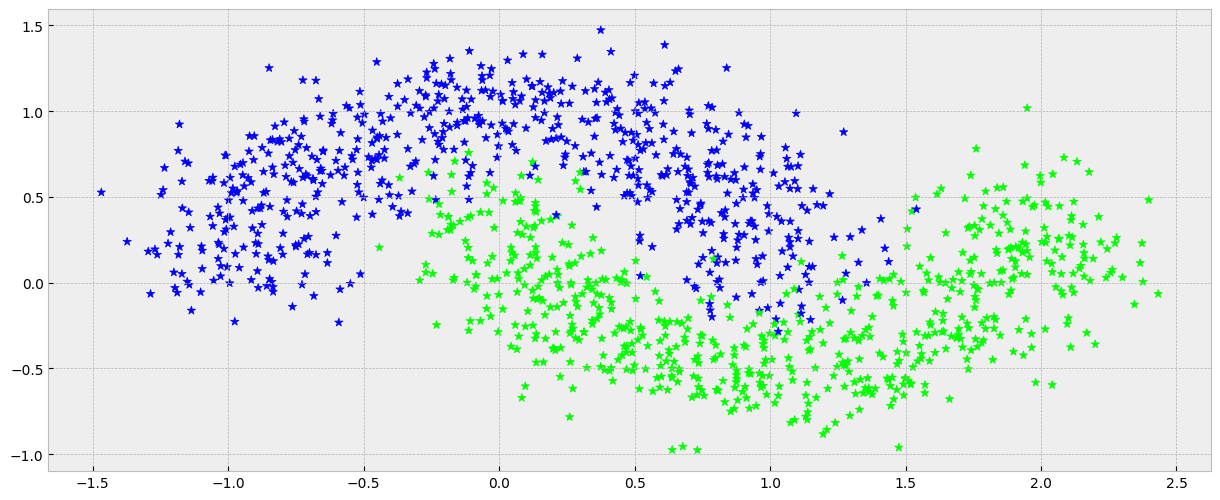

In [5]:
X, y = datasets.make_moons(n_samples=NUM_SAMPLES, 
                           shuffle=True, 
                           noise=NOISE, 
                           random_state=RANDOM_STATE)

# Lets Plot the data
plt.scatter(X[:,0], X[:,1], s=40, c=y, marker='*', cmap=CMAP);

In [6]:
def fn_plot_decision_boundary(model, X, y):
    
    # Set min and max values and give it some padding
    xMin, xMax = X[:, 0].min() - .05, X[:, 0].max() + .05
    yMin, yMax = X[:, 1].min() - .05, X[:, 1].max() + .05
    
    # grid size for mesh grid
    h = 0.01
    
    # Generate a grid of points with distance 'h' between them
    xx, yy = np.meshgrid(np.arange(xMin, xMax, h), np.arange(yMin, yMax, h))
    
    # Predict the function value for the whole grid
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])

    Z = Z.argmax(axis = 1) # Take max argument
    
    # Make its shape same as that of xx 
    Z = Z.reshape(xx.shape)
    
    # Now we have Z value corresponding to each of the combination of xx and yy
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=CMAP, alpha = 0.6)
    
    # plot the points as well
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=CMAP, edgecolors='black')

In [7]:
#  Split the data in training and test sets to measure performance of the model.
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    stratify=y,
                                                    test_size=TEST_SIZE,
                                                    random_state=RANDOM_STATE )

print (X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(1024, 2) (1024,) (256, 2) (256,)


## Single neuron
<img src="../../images/dnn_nb_s03_fig2.jpg" width='350' align = 'left'>
<img src="../../images/dnn_nb_s03_fig3.jpg" width='550' align = 'right'>

### For single perceptron:
   
$$
\begin{aligned}
a &=  \sigma(z)\\
a &=  \sigma(x_1 \circ w_1 + x_2 \circ w_2 + b)\\ 
a &= \sigma\ ( [ x_1, x_2 ] \circ
\begin{bmatrix} w_1 \\ w_2 \end{bmatrix}  + b )\\
\end{aligned}
$$

#### For multiple Rows of X:

$$
\begin{aligned}
a &= \sigma\ (\begin{bmatrix} x_1^{(1)} & x_2^{(1)}\\ 
x_1^{(2)} & x_2^{(2)}\\
x_1^{(...)} & x_2^{(...)}\\
x_1^{(m)} & x_2^{(m)} \end{bmatrix} \circ
\begin{bmatrix} w_1 \\ w_2 \end{bmatrix}  + b )\\
\end{aligned}
$$

In matrix form it can be represented as:

$
\begin{aligned}
a &= \sigma\ ( X_{shape = (m,2)} \circ W_{shape = (2,1)}^{[1]} + b_{shape = (1,1)})
\end{aligned}
$

**Note:** Please note that Python is going to broadcast b in all $'m'$ rows. Avoid any confusion, always maintain dimensions of $b$.

## Neural Network

Let's start with simple network. Our data has **two** features. Hence size of input layer will also be two. The output is binary, we can code it as single column as well as double column output. The hidden layer could be of **any size**. One need to execute a handful of iterations to arrive at right size of hidden layer. For purpose of today's discussions, size of hidden layer is taken as shown below.
<img src = '../../images/dnn_nb_s04_fig1.jpg' width = '400px' align= 'left'/>
<img src = '../../images/dnn_nb_s04_fig2.jpg' width = '400px' align= 'right'/>

We will be using $\tanh$ function for layer 1 (hidden layer) as it fits in majority of cases and its derivative can simply be represented as 1 -$\tanh^2(z_1)$. Since our output is binary, it makes sense to use $\text{Sigmoid}$ in the last layer.

## Forward Propagation

### For single Neuron:
$
\begin{aligned}
a &= \text{activation function} ( X \circ W_1 + b)\\
\end{aligned}
$

Hence for hidden layer, we can write as follows:

$
\begin{aligned}
z_1^{[1]} & = X . W_1^{[1]} + b_1^{[1]}\\
a_1^{[1]} & = \tanh(z_1^{[1]}) \\
\\
z_2^{[1]} & = X . W_2^{[1]} + b_2^{[1]} \\
a_2^{[1]} & = \tanh(z_2^{[1]}) \\
\\
z_3^{[1]} & = X . W_3^{[1]} + b_3^{[1]} \\
a_3^{[1]} & = \tanh(z_3^{[1]}) \\
\\
z_4^{[1]} & = X . W_4^{[1]} + b_4^{[1]} \\
a_4^{[1]} & = \tanh(z_4^{[1]}) \\
\\
\text{Or}\\
a^{[1]} &= \tanh(X \circ \begin{bmatrix} W_1^{[1]}, &W_2^{[1]}, &W_3^{[1]}, &W_4^{[1]}\end{bmatrix} + b^{[1]} )\\
\end{aligned}
$



<hr>

If we convert above to matrix version, we can say.

$
\begin{aligned}
z_{shape = (m,4)}^{[1]} & = X_{shape = (m,2)} \circ W_{shape=(2,4)}^{[1]} + b_{shape = (1,4)}^{[1]} \\
\\
a_{shape = (m,4)}^{[1]} & = \tanh(z^{[1]}) \\
\end{aligned}
$

Similarly for second layer.

$
\begin{aligned}
z_{shape = (m, 1)}^{[2]} & = a_{shape = (m,4)}^{[1]} \circ W_{shape=(4,1)}^{[2]} + b_{shape = (1,1)}^{[2]} \\
\\
a_{shape = (m, 1)}^{[2]} & = \hat{y} = \mathrm{sigmoid}(z^{[2]})\\
\end{aligned}
$

Where:

Sigmoid $\sigma$: 

$\sigma(z) = \dfrac{1}{1 + e^{-z}}$

## Loss Function

We need to minimize the error by adjusting ($Ws, bs$). We call the function that measures our error the <b>loss function</b>. A common choice with the sigmoid output is the cross-entropy loss. The loss for predictions $\hat{y}$ with respect to the true labels $y$ is given by:

$
\begin{aligned}
L(\hat{y_i}, y_i) =  -[y_i.log\hat{y_i} + (1 - y_i) . log(1-\hat{y_i})]
\end{aligned}
$

For all samples:

$
\begin{aligned}
J(\hat{y}, y) =  -\frac{1}{m}\sum_{i=1}^{m}[y_i.log\hat{y}_i + (1-y_i) . log(1-\hat{y}_i)]
\end{aligned}
$

### In case of Binary Classification:

$
\begin{aligned}
L(\hat{y_i}, y_i) =  -y_i.log\hat{y_i}
\end{aligned}
$

For all samples:

$
\begin{aligned}
J(\hat{y}, y) =  -\frac{1}{m}\sum_{i=1}^{m}y_i.log\hat{y}_i
\end{aligned}
$


We can use gradient descent to find its minimum. For purpose of this Session, let's use it in its simplest form - <b>batch gradient descent with fixed learning rate</b>.

## For a single row of data x,

<img src='../../images/dnn_nb_s04_fig3.jpg' style='width: 800px;'/>

As an input, gradient descent needs the gradients (vector of derivatives) of the loss function with respect to our parameters: 

$\frac{\partial{L}}{\partial{W_1}}(= \partial{W^{[1]}})$, $\frac{\partial{L}}{\partial{b_1}}(= \partial{b^{[1]}})$, $\frac{\partial{L}}{\partial{W_2}}(= \partial{W^{[2]}})$, $\frac{\partial{L}}{\partial{b_2}}(= \partial{b^{[2]}})$. 

To calculate these gradients we use the <b>back-propagation algorithm</b>.

**Note:** Loss is a function of $a^{[2]}$ which is a function of $z^{[2]}$ and so on. It can be further represented as follows:<br>
$
\begin{aligned}
Loss &= f_1(a^{[2]})\\
a^{[2]} &= f_2(z^{[2]})\\
z^{[2]} &= f_3(a^{[1]})\\
a^{[1]} &= f_4(z^{[1]})\\
\text{Therefore:}\\
\frac{\partial{Loss}}{\partial{z^{[1]}}} &= \frac{\partial{Loss}}{\partial{z^{[2]}}} \circ
\frac{\partial{z^{[2]}}}{\partial{a^{[1]}}} \circ \frac{\partial{a^{[1]}}}{\partial{z^{[1]}}} 
\end{aligned}
$
</div>

## Back-propagation for all Rows
For all rows, equations will remain same and the values will be divided by <b><i>'m'</i></b>; number of samples.

$
\begin{aligned}
\partial{z^{[2]}}  & = a^{[2]} - y  \\
\partial{W^{[2]}}  & = \frac{1}{m} a^{[1]T}\circ \partial{z^{[2]}} \\
\partial{b^{[2]}}  & = \frac{1}{m} \mathrm{np.sum}(\partial{z^{[2]}}, axis = 0, keepdims = True) \\
\\
\partial{z^{[1]}}  & = \partial{z^{[2]}}\circ  W^{[2]T} * ( 1-a^{[1]}**2)\\
\partial{W^{[1]}}  & = \frac{1}{m} X^{T}\circ \partial{z^{[1]}} \\
\partial{b^{[1]}}  & = \frac{1}{m} \mathrm{np.sum}(\partial{z^{[1]}}, axis = 0, keepdims = True) \\
\\
\end{aligned}
$

## Notes:


We have transposed a few matrices in above calculations such as $a^{[1]}$, $W^{[2]}$ and X. A review of shapes of matrices will reveal that this adjustment is needed to have consistent sizes. e.g.

- Shape of $a^{[1]}$ and $\partial{z}^{[2]}$ are ( m, 4) and ( m, 1 ) respectively. Expected shape of $\partial{W^{[2]}}$ is ( 4, 1 ) which is same as that of $W^{[2]}$.
- In equation $\partial{z^{[1]}}  = \partial{z^{[2]}}\circ  W^{[2]T} * ( 1-a^{[1]}**2)$ shape of $z^{[2]}$,  $W^{[2]}$ and $a^{[1]}$ are (m,1), (4,1) and (m,4). For element wise multiplication, expected shape of dot product of is $z^{[2]}$ and $W^{[2]}$ is ( m, 4 ).
- Lastly, shape of $\partial{W^{[1]}}$ is (2,4) and that of X and $\partial{z^{[1]}}$ are ( m, 2 ) and ( m, 4 ).

In [8]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()

X_train = sc.fit_transform(X_train)

X_test = sc.transform(X_test)

## Prepare Model

Build `tf.keras.Sequential` model by taking `tf.keras.layers.Dense`

In [9]:
#tf.keras.layers.Dense?

In [10]:
# model = tf.keras.models.Sequential()
# model.add(tf.keras.Input(shape=(2,)))
# model.add(tf.keras.layers.Dense(4, activation='relu'))
# # Now the model will take as input arrays of shape (None, 2)
# # and output arrays of shape (None, 312).
# # Note that after the first layer, you don't need to specify
# # the size of the input anymore:
# model.add(tf.keras.layers.Dense(1))
# model.output_shape

In [11]:
model = tf.keras.Sequential([ 
    tf.keras.layers.Dense(4, activation='tanh'),
    tf.keras.layers.Dense(2) # Two outputs for two classes
    ])
#model.output_shape

2024-06-15 19:00:49.777679: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-15 19:00:49.830233: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-15 19:00:49.830679: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [12]:
X_train[:1].shape

(1, 2)

In [13]:
predictions = model(X_train[:1])
predictions.numpy().sum()

0.18032122

In [14]:
tf.nn.softmax(predictions).numpy().sum()

1.0

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (1, 4)                    12        
                                                                 
 dense_1 (Dense)             (1, 2)                    10        
                                                                 
Total params: 22 (88.00 Byte)
Trainable params: 22 (88.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [16]:
import sys
sys.float_info.max, sys.float_info.min

(1.7976931348623157e+308, 2.2250738585072014e-308)

In [17]:
np.log(sys.float_info.max)

709.782712893384

In [18]:
# np.exp(710)

In [19]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True)

In [20]:
y_train[:1]

array([0])

In [21]:
loss_fn(y_train[:1], predictions).numpy()

0.78652674

In [22]:
#model.fit?

## Compile the model:
- Loss Function
- Optimizer
- list metrics to monitor

## Fit the model
- Training features
- Training target
- validations
- batch_size
- epochs


In [23]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=ALPHA),
              loss=loss_fn,
              metrics=['accuracy'])

history = model.fit(x=X_train,
                    y=y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    verbose='auto',
                    validation_data=[X_test, y_test])

Epoch 1/500


2024-06-15 19:00:50.765709: I external/local_xla/xla/service/service.cc:168] XLA service 0x7cb9260b67a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-06-15 19:00:50.765735: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
2024-06-15 19:00:50.771633: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-06-15 19:00:50.789324: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902
I0000 00:00:1718458250.889859   20970 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


32/32 [==============================] - 1s 7ms/step - loss: 0.5914 - accuracy: 0.7217 - val_loss: 0.5315 - val_accuracy: 0.7695
Epoch 2/500
32/32 [==============================] - 0s 3ms/step - loss: 0.5339 - accuracy: 0.7500 - val_loss: 0.4747 - val_accuracy: 0.8242
Epoch 3/500
32/32 [==============================] - 0s 3ms/step - loss: 0.4881 - accuracy: 0.7842 - val_loss: 0.4326 - val_accuracy: 0.8320
Epoch 4/500
32/32 [==============================] - 0s 3ms/step - loss: 0.4531 - accuracy: 0.8057 - val_loss: 0.3982 - val_accuracy: 0.8398
Epoch 5/500
32/32 [==============================] - 0s 2ms/step - loss: 0.4256 - accuracy: 0.8252 - val_loss: 0.3710 - val_accuracy: 0.8633
Epoch 6/500
32/32 [==============================] - 0s 2ms/step - loss: 0.4040 - accuracy: 0.8330 - val_loss: 0.3489 - val_accuracy: 0.8711
Epoch 7/500
32/32 [==============================] - 0s 3ms/step - loss: 0.3870 - accuracy: 0.8447 - val_loss: 0.3311 - val_accuracy: 0.8711
Epoch 8/500
32/32 [======

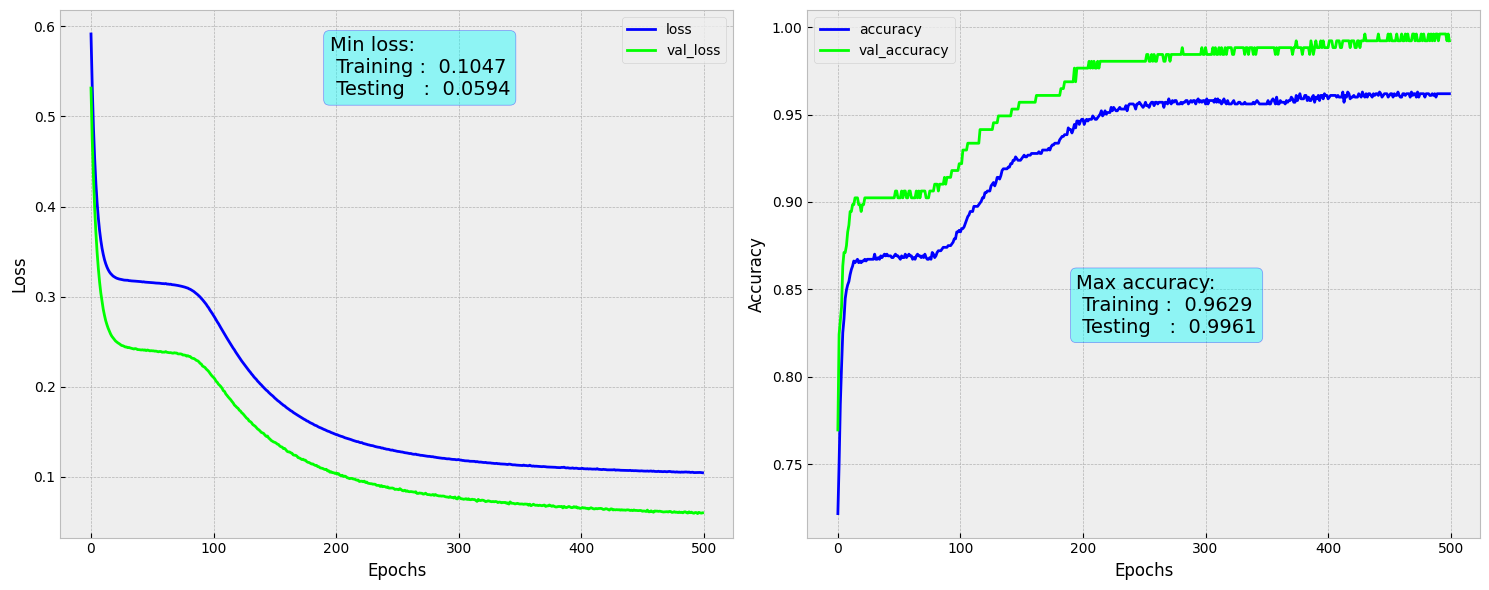

In [24]:
hist_df = pd.DataFrame(history.history)
fn_plot_hist(hist_df)

In [25]:
hist_df[hist_df['val_loss'] == hist_df['val_loss'].min()]

,loss,accuracy,val_loss,val_accuracy
495,0.105081,0.961914,0.059392,0.996094


6636/6636 [==============================] - 6s 827us/step


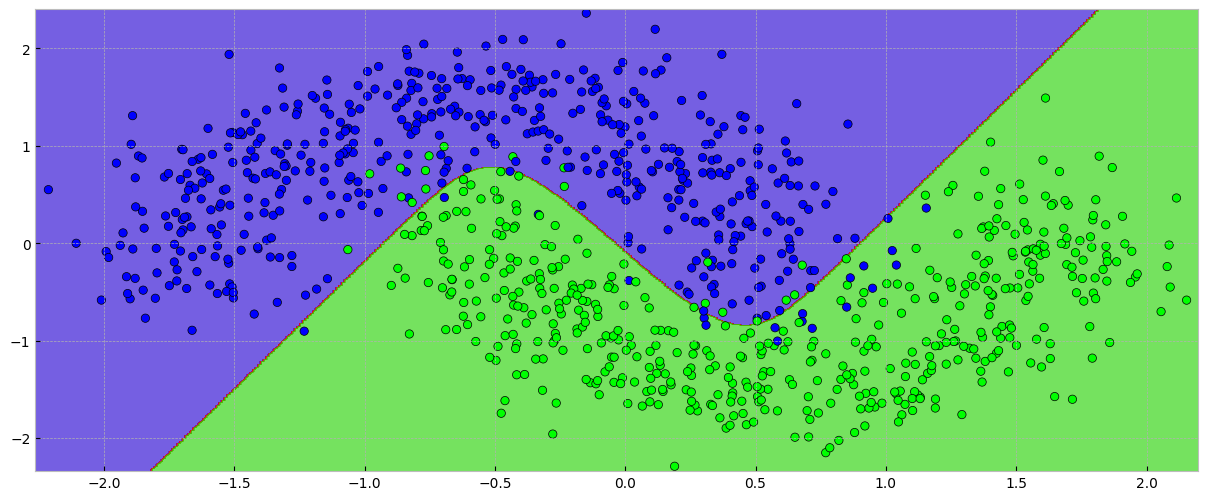

In [28]:
fn_plot_decision_boundary(model, X_train, y_train)

### Would contest that we should have used higher epochs as loss is still coming down? How many epochs are sufficient?

In [27]:
y_pred = predict(model, X_train)
print('Accuracy score on Train Data :', accuracy_score(y_train, y_pred))

NameError: name 'predict' is not defined

In [ ]:
print(classification_report(y_train, y_pred))

In [ ]:
y_pred = predict(model, X_test)

print('Accuracy score on Test Data :', accuracy_score(y_test, y_pred))

In [ ]:
print(classification_report(y_test, y_pred))

In [ ]:
loss_df = pd.DataFrame(loss_hist)

fn_plot_decision_boundary(lambda x: predict(model, x), X_train, y_train) # plot decision boundary for this plot

plt.title("Decision Boundary");

In [ ]:
fig, axes = plt.subplots(1,2 , figsize = (15,6))

l_range = 50

ax = axes[0]

loss_df.plot(x = 'epoch', y = 'loss', ax = ax)
loss = loss_df['loss'].values

# little beautification
txtstr = "Errors: \n  Start : {:7.4f}\n   End : {:7.4f}".format(loss[0],loss[-1]) #text to plot
# properties  matplotlib.patch.Patch 
props = dict(boxstyle='round', facecolor='cyan', alpha=0.5, edgecolor = 'b')

# place a text box in upper left in axes coords

ax.text(0.6, 0.95, txtstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

ax.set_xlabel("Epochs")
ax.set_ylabel("Error")
ax.set_title('Overall')

ax = axes[1]

loss_df[-l_range:].plot(x = 'epoch', y = 'loss', ax = ax)

# little beautification
txtstr = "Errors: \n  Start : {:7.4f}\n   End : {:7.4f}".format(loss[-l_range],loss[-1]) #text to plot
# properties  matplotlib.patch.Patch 
props = dict(boxstyle='round', facecolor='cyan', alpha=0.5, edgecolor = 'b')

# place a text box in upper left in axes coords

ax.text(0.6, 0.95, txtstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

ax.set_xlabel("Epochs")
ax.set_ylabel("Error")
ax.set_title('Last {} records'.format(l_range))

plt.tight_layout()

In [ ]:
cm  = confusion_matrix(y_test, y_pred)
cm

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=[0,1])

fig, ax = plt.subplots(figsize = (4,4))

disp.plot(ax = ax, cmap = 'Blues', colorbar=False)

plt.show();

# Assignment: S06-A01
-	Prepare table by changing number of neurons in hidden layer, learning rate and observe change in results. Also comment on your results.

|#|Dimension of hidden layer|Learning rate|Training Accuracy|Test Accuracy|Comment|
|:-:|:-:|:-:|:-:|:-:|:--|
|1|4|0.1|0.97|0.96|Base case||1|4|0.1|0.97|0.96|Base case|
|2|1|1|???|???|???|
|...|...|...|...|...|...|
|n|...|...|...|...|...|

-	What lines will you change to convert it into multi-class prediction model?